# Imports

## Libraries

In [1474]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import category_encoders as ce


import folium
import plotly.express as px
from scipy import stats
from sklearn.tree import export_graphviz
import graphviz

set_config(transform_output = "pandas")

## Data

In [1475]:
file_dir = r'C:\Users\Usuario\Desktop\Proyects\Machine Learning\data'
file_name =  r"\sample_mmp.csv"
df = pd.read_csv(file_dir + file_name, sep = ",")

n_filas = int(len(df)*1)
df = df.sample(n = n_filas, random_state = 42)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_26352\2682143424.py:3: DtypeWarning: Columns (29,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_dir + file_name, sep = ",")


# Functions

#### Feature analysis

In [1476]:
def category_lists(dataframe, list):
    cols_to_OHE = []
    cols_to_ordinal = []
    cols_to_mf = []
    for c in dataframe[list]:
        n_cat = dataframe[c].nunique()
        if 5<= n_cat <=20:
            cols_to_OHE.append(c)
        elif n_cat > 20:
            cols_to_ordinal.append(c)
        else:
            cols_to_mf.append(c)
    return cols_to_OHE, cols_to_ordinal, cols_to_mf

In [1477]:
def bolean_var(dataframe):
    bolean_vars = []
    for var in dataframe.columns:
        if dataframe[var].nunique() == 2:
            bolean_vars.append(var)
    return bolean_vars

In [1478]:
def missing_percent(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(50)

In [1479]:
def detect_outliers(df):
    outlier_vars = []
    
    summary = df.describe()
    IQR = summary.loc['75%'] - summary.loc['25%']
    
    lower_bound = summary.loc['25%'] - 1.5 * IQR
    upper_bound = summary.loc['75%'] + 1.5 * IQR
    
    for col in df.select_dtypes(include='number').columns:
        outliers_lower = df[col] < lower_bound[col]
        outliers_upper = df[col] > upper_bound[col]
        
        if outliers_lower.any() or outliers_upper.any():
            outlier_vars.append(col)
    
    return outlier_vars

#### Feature enginering

In [1480]:
def var_low_variance(dataframe):
    low_variance_cols = []
    unbalanced_cols = []
    
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        if len(unique_values) <= 2:  # Variables binarias o categóricas con 2 valores únicos
            value_counts = dataframe[column].value_counts(normalize=True, dropna=False)
            if len(value_counts) == 1 or (len(value_counts) == 2 and value_counts.max() >= 0.95):
                low_variance_cols.append(column)
            elif len(value_counts) == 2 and value_counts.max() >= 0.95:
                unbalanced_cols.append(column)
        else:  # Variables categóricas con más de 2 valores únicos
            value_counts = dataframe[column].value_counts(normalize=True, dropna=False)
            if value_counts.max() >= 0.95:
                unbalanced_cols.append(column)
    
    return low_variance_cols, unbalanced_cols

In [1481]:
def convert_cat_bool(df, cols):
    for col in cols:
        moda_category = df[col].value_counts().idxmax()
        prefix = str(moda_category)
        new_column_name = f"{col}_{prefix}"
        df[new_column_name] = df[col].apply(lambda x: 1 if x == prefix else 0)
        df.drop(columns=col, inplace=True)
    return df

In [1482]:
def numeric_lists_transf(df, num_cols):
    minmaxscaler_vars = []
    log_vars = []
    
    summary = df.describe()
    IQR = summary.loc['75%'] - summary.loc['25%']
    
    lower_bound = summary.loc['25%'] - 1.5 * IQR
    upper_bound = summary.loc['75%'] + 1.5 * IQR
    
    for col in num_cols:
        outliers_lower = df[col] < lower_bound[col]
        outliers_upper = df[col] > upper_bound[col]
        
        if outliers_lower.any() or outliers_upper.any():
            log_vars.append(col)
        else:
            minmaxscaler_vars.append(col)

    return log_vars, minmaxscaler_vars

#### Modelling

In [1483]:
def validation_strategy_cl(dataframe, TARGET):
    X_train_, X_val, y_train_, y_val = train_test_split(dataframe.drop(TARGET, axis=1), dataframe[TARGET], test_size=0.15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size = 0.20, random_state = 42)
    X_train_, X_val, y_train_, y_val = train_test_split(dataframe.drop(TARGET, axis=1), dataframe[TARGET], test_size=0.15, random_state=42)
    return X_train, X_test, y_train, y_test, X_val, y_val

In [1484]:
def predictions_cl(X_test, y_test, X_val, y_val, Algorithm):
    y_test_pred = pd.DataFrame(Algorithm.predict(X_test), index=y_test.index, columns=[TARGET])
    acc_test = Algorithm.score(X_test, y_test)
    acc_val = Algorithm.score(X_val, y_val)
    f1 = f1_score(y_test, y_test_pred)
    y_proba = Algorithm.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    return print(f'Accuracy test: {round(acc_test, 3)}, Accuracy validation: {round(acc_val, 3)}, F1 score: {round(f1, 3)}, AUC: {round(auc, 3)}')

In [1485]:
def AUC_pred(X, Y, algorithm):
    y_proba = algorithm.predict_proba(X)[:, 1]
    auc = roc_auc_score(Y, y_proba)
    return print("AUC:", auc)

In [1486]:
def paint_confusion_matrix(X_test, y_test, algorithm):
    y_pred = algorithm.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    return plt.show()

In [1487]:
def paint_roc_curve(X_test, y_test, algorithm):
    y_proba = algorithm.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)

    plt.clf()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

In [1535]:
def models_comparison_roc_curve(X_train, y_train, X_test, y_test, model_1, model_2, model_3):

    models = [ 
        (model_1),
        (model_2),
        (model_3)
    ]
    plt.clf()
    for model in models:
        model_name = model[0]
        model_instance = model[1]
        model_instance.fit(X_train, np.ravel(y_train))
        predictions = model_instance.predict_proba(X_test)[:,1]
        auc_score = metrics.roc_auc_score(y_test, predictions)
        print('ROC AUC Score for {}: {}'.format(model_name, round(auc_score, 3)))
        fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
        plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    return plt.show()

In [1489]:
df = df.set_index('MachineIdentifier')
df.drop('Unnamed: 0', axis = 1, inplace = True)

# Preprocessing

In [1490]:
df.shape

(500000, 82)

Target

In [1491]:
TARGET = ['HasDetections']

Low variance

In [1492]:
low_variance_cols, unbalanced_cols = var_low_variance(df)

In [1493]:
print('Low variance cols: ',len(low_variance_cols))
print('Unbalanced cols: ',len(unbalanced_cols))

Low variance cols:  7
Unbalanced cols:  12


In [1494]:
#unbalanced_cols
#low_variance_cols

In [1495]:
df_c = df.drop(low_variance_cols + unbalanced_cols + ['Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical'], axis =1)

In [1496]:
df_c.shape

(500000, 61)

## Nulls

In [1497]:
missing_percent(df_c).head(34)

,Total,Percent
Census_IsFlightingInternal,415225,83.0450
Census_InternalBatteryType,355603,71.1206
Census_ThresholdOptIn,318104,63.6208
Census_IsWIMBootEnabled,317666,63.5332
SmartScreen,178596,35.7192
OrganizationIdentifier,154563,30.9126
SMode,29848,5.9696
CityIdentifier,18240,3.6480
Wdft_RegionIdentifier,16950,3.3900
Wdft_IsGamer,16950,3.3900


In [1498]:
df_c.columns

Index(['EngineVersion', 'AppVersion', 'AvSigVersion',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'CountryIdentifier',
       'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'Processor', 'OsBuild', 'OsSuite',
       'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'IsProtected',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Census_MDC2FormFactor',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
       'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM',
       'Census_ChassisTypeName',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_PowerPlatformRoleName', 'Census_InternalBatteryType',
       'Census_InternalBatteryNumberOfCharges', 'Censu

In [1499]:
#df_c.drop('DefaultBrowsersIdentifier', axis = 1, inplace = True)

Dtype

In [1500]:
cols_to_obj = ['AVProductsInstalled', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 
 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IeVerIdentifier', 'Census_OEMNameIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier', 'Census_FirmwareManufacturerIdentifier', 'Wdft_RegionIdentifier']

In [1501]:
df_c[cols_to_obj] = df_c[cols_to_obj].astype(str)

In [1502]:
boolean_columns = bolean_var(df_c)
boolean_columns = [x for x in boolean_columns if x not in TARGET]
numeric_columns = df_c.select_dtypes(include = 'number').drop(TARGET, axis = 1).columns
numeric_columns = [x for x in numeric_columns if x not in boolean_columns]
object_columns = df_c.select_dtypes(include = ['object', 'string']).columns

In [1503]:
cols_constant_1 = ['Census_ThresholdOptIn', 'Census_IsFlightingInternal', 'Census_IsWIMBootEnabled']
boolean_columns = [x for x in boolean_columns if x not in cols_constant_1]
numeric_columns = [x for x in numeric_columns if x not in cols_constant_1]

In [1504]:
(len(boolean_columns) + len(numeric_columns) + len(object_columns) + len(cols_constant_1)) - len(df_c.columns)

-1

In [1505]:
impute_pipe = ColumnTransformer(transformers = [
    ("median", SimpleImputer(strategy = "median"), numeric_columns),
    ("mf", SimpleImputer(strategy = "most_frequent"), object_columns),
    ("mf_b", SimpleImputer(strategy = "most_frequent"), boolean_columns),
    ("lf", SimpleImputer(strategy = "constant", fill_value= 1), cols_constant_1)
], remainder = 'passthrough')

In [1506]:
df_c = impute_pipe.fit_transform(df_c)

In [1507]:
missing_percent(df_c).head(4)

,Total,Percent
median__AVProductStatesIdentifier,0,0.0
mf__Census_ChassisTypeName,0,0.0
mf__Census_InternalBatteryType,0,0.0
mf__Census_InternalBatteryNumberOfCharges,0,0.0


## Transformers

In [1508]:
df_t = df_c

In [1509]:
TARGET = ['remainder__HasDetections']

In [1510]:
boolean_columns = bolean_var(df_t)
boolean_columns = [x for x in boolean_columns if x not in TARGET]
numeric_columns = df_c.select_dtypes(include = 'number').drop(TARGET, axis = 1).columns
numeric_columns = [x for x in numeric_columns if x not in boolean_columns]
object_columns = df_c.select_dtypes(include = ['object', 'string']).columns

In [1511]:
cols_to_OHE, cols_to_ordinal, cols_to_mf = category_lists(df_t, object_columns)

In [1512]:
#cols_to_mf
#cols_to_ordinal
#cols_to_OHE

In [1513]:
outlier_vars = detect_outliers(df_t[numeric_columns])
print("Probably outliers:")
print(outlier_vars)

Probably outliers:
['median__AVProductStatesIdentifier', 'median__Census_OEMModelIdentifier', 'median__Census_PrimaryDiskTotalCapacity', 'median__Census_SystemVolumeTotalCapacity', 'median__Census_TotalPhysicalRAM', 'median__Census_InternalPrimaryDiagonalDisplaySizeInInches']


In [1514]:
#df_t[numeric_columns].describe().T
#df_t[boolean_columns].describe().T

In [1515]:
log_vars, minmaxscaler_vars = numeric_lists_transf(df_t, numeric_columns)
print("Variables para transformación logarítmica:", log_vars)
print("Variables para MinMaxScaler:", minmaxscaler_vars)

Variables para transformación logarítmica: ['median__AVProductStatesIdentifier', 'median__Census_OEMModelIdentifier', 'median__Census_PrimaryDiskTotalCapacity', 'median__Census_SystemVolumeTotalCapacity', 'median__Census_TotalPhysicalRAM', 'median__Census_InternalPrimaryDiagonalDisplaySizeInInches']
Variables para MinMaxScaler: ['median__Census_OSUILocaleIdentifier', 'median__Census_FirmwareVersionIdentifier']


In [1516]:
missing_column = set(df_t.columns) - set(minmaxscaler_vars + log_vars + cols_to_OHE + cols_to_ordinal + cols_to_mf + boolean_columns)
print("Columna faltante:", missing_column)

Columna faltante: {'remainder__HasDetections'}


In [1517]:
convert_bol_t = FunctionTransformer(func=lambda X: convert_cat_bool(X, cols=cols_to_mf), validate=False)
log_trans = FunctionTransformer(func=lambda X: np.log(X))

transform_pipe = ColumnTransformer(transformers=[
    ("scaler", MinMaxScaler(), minmaxscaler_vars),
    ("log", log_trans, log_vars),
    ("encoder", OneHotEncoder(sparse_output=False), cols_to_OHE),
    ("ordinal", OrdinalEncoder(), cols_to_ordinal),
    ('bool', convert_bol_t, cols_to_mf)
], remainder='passthrough')

In [1518]:
df_t2 = transform_pipe.fit_transform(df_t)

# Modelling

## Validation strategy

In [1519]:
df_t2.columns[df_t2.isnull().any()]

Index([], dtype='object')

In [1520]:
TARGET = ['remainder__remainder__HasDetections']

In [1521]:
X_train, X_test, y_train, y_test, X_val, y_val = validation_strategy_cl(df_t2, TARGET)

## Decision Tree

In [1522]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000,random_state=42,)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000, random_state=42)

In [1523]:
predictions_cl(X_test, y_test, X_val, y_val, dt)

Accuracy test: 0.613, Accuracy validation: 0.613, F1 score: 0.642, AUC: 0.654


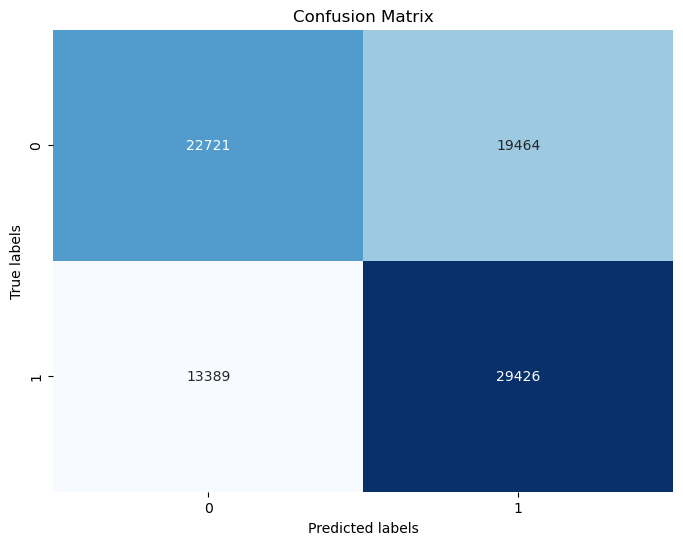

In [1524]:
paint_confusion_matrix(X_test, y_test, dt)

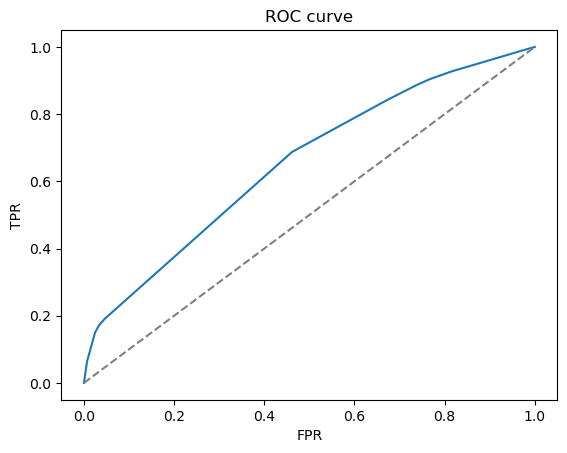

In [1525]:
paint_roc_curve(X_test, y_test, dt)

## Random Forest

In [1526]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

c:\Users\Usuario\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=5, random_state=42)

In [1527]:
predictions_cl(X_test, y_test, X_val, y_val, rf)

Accuracy test: 0.621, Accuracy validation: 0.62, F1 score: 0.643, AUC: 0.677


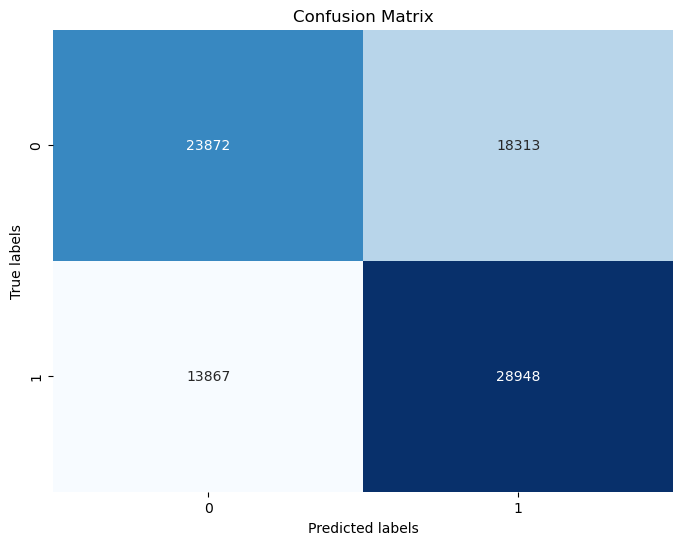

In [1528]:
paint_confusion_matrix(X_test, y_test, rf)

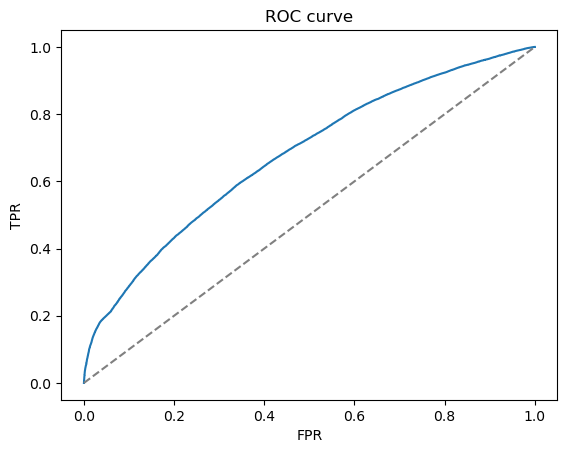

In [1529]:
paint_roc_curve(X_test, y_test, rf)

# Gradient Boosting

In [1530]:
gb = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [1531]:
predictions_cl(X_test, y_test, X_val, y_val, gb)

Accuracy test: 0.64, Accuracy validation: 0.639, F1 score: 0.641, AUC: 0.699


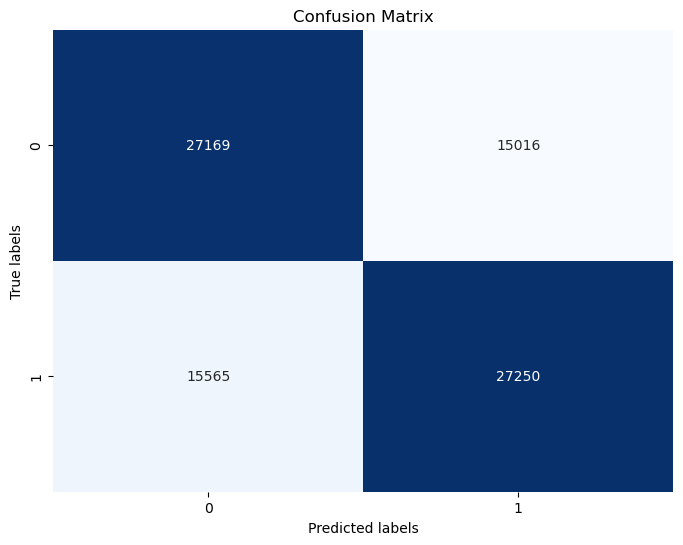

In [1532]:
paint_confusion_matrix(X_test, y_test, gb)

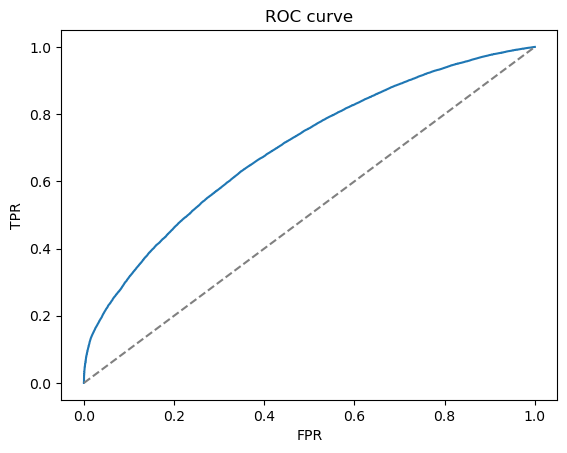

In [1533]:
paint_roc_curve(X_test, y_test, gb)

## Model comparison

ROC AUC Score for Decision Tree: 0.654
ROC AUC Score for Random Forest: 0.677
ROC AUC Score for Gradient Boosting: 0.699


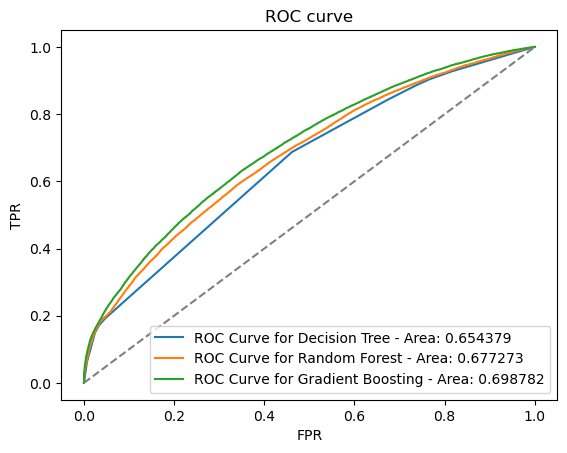

In [1536]:
models_comparison_roc_curve(X_train, y_train, X_test, y_test, ('Decision Tree', dt), ('Random Forest', rf), ('Gradient Boosting', gb))